In [ ]:
# Sentiment analysis on IMDB movie reviews with Naïve Bayes"

In [ ]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## Loading data
#We retrieve the textual data in the variable *texts*
#The labels are retrieved in the variable $y$
#- it contains *len(texts)* of them: 
#$0$ indicates that the corresponding review is negative 
#while $1$ indicates that it is positive."


In [ ]:
from glob import glob
    # We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
#train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
#train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))
train_filenames_neg = sorted(glob(op.join('.', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'pos', '*.txt')))

#test_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'test', 'neg', '*.txt')))
#test_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'test', 'pos', '*.txt')))

#test_filenames_neg = sorted(glob(op.join('.', 'neg', '*.txt')))
#test_filenames_pos = sorted(glob(op.join('.', 'pos', '*.txt')))   


    # Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos
#test_texts_neg = [open(f, encoding="utf8").read() for f in test_filenames_neg]
#test_texts_pos = [open(f, encoding="utf8").read() for f in test_filenames_pos]
#test_texts = test_texts_neg + test_texts_pos

    # The first half of the elements of the list are string of negative reviews, and the second half positive ones
    # We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to

train_labels = np.ones(len(train_texts), dtype=int)
train_labels[:len(train_texts_neg)] = 0
#test_labels = np.ones(len(test_texts), dtype=int)
#test_labels[:len(test_texts_neg)] = 0



In [ ]:
#open("/neg/0_3.txt", encoding="utf8").read()
#In this lab, the impact of our choice of representations
#upon our results will also depend on the quantity of data we use:** 
#try to see how changing the parameter ```k``` affects our results !"


In [ ]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews

k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]
print('Number of documents:', len(train_texts_reduced))

Number of documents: 2500


In [ ]:
#We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:"

from sklearn.model_selection import train_test_split

train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

In [ ]:
## Adapted representation of documents\n",

#Our statistical model, like most models applied to textual data, uses counts of word occurrences 
#in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, 
#containing the counts of each word (regardless of their order of occurrence) in the document.

#If we consider the set of all the words appearing in our $T$ training documents, 
#which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to 
#each $w$ word an integer, which will be its position in $V$.
#Thus, for a document extracted from a set of documents containing $|V|$ different words, 
#a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ 
#will be its number of occurrences in the document

#We can use the **CountVectorizer** class from scikit-learn to obtain these representations:"

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
             'I walk down the the avenue']
vectorizer = CountVectorizer()
Bow = vectorizer.fit_transform(corpus)
# Vocabulary of the corpus
print(vectorizer.get_feature_names())

# Vecteur Bag of words
Bow.toarray()


['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

In [ ]:
#We display the list containing the words ordered according to their index (Note that words
#of 2 characters or less are not counted).

In [ ]:
## Preprocessing the text: get the BoW representations ##\n",

#The first thing to do is to turn the review from a string into a list of words.
#The simplest method is to divide the string according to spaces with the command:``text.split()``

#But we must also be careful to remove special characters that may not have been cleaned up 
#(such as HTML tags if the data was obtained from web pages). Since we're going to count words, 
#we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this
 #list and make it uniform (ignore capitalization, punctuation, and the shortest words). 
#We will therefore use a function adapted to our needs - but this is a job that we generally don't
 #need to do ourselves, since there are many tools already adapted to most situations. 
#For text cleansing, there are many scripts, based on different tools (regular expressions, 
#for example) that allow you to prepare data. The division of the text into words and the management 
#of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains
#many different *tokenizers*.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# We might want to clean the file with various strategies:\n",
def clean_and_tokenize(text):

           #Cleaning a document with:\n",
    #        - Lowercase        \n",
    #       - Removing numbers with regular expressions\n",
    #        - Removing punctuation with regular expressions\n",
    #        - Removing other artifacts\n",
    #    And separate the document into words by simply splitting at spaces\n",
    #    Params:\n",
    #        text (string): a sentence or a document\n",
    #    Returns:\n",
    #        tokens (list of strings): the list of tokens (word units) forming the document\n",
    #    \"\"\"     
    
    # Lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)

    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()[\]]")
    text = REMOVE_PUNCT.sub("", text)

    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)

    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    tokens = text.split()       
    return tokens


    # Or we might want to use an already-implemented tool. The NLTK package has a lot of very 
    #useful text processing tools, among them various tokenizers
    # Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses.
    #Check the documentation !

from nltk.tokenize import word_tokenize
    
corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
    
print(clean_and_tokenize(corpus_raw))
print(word_tokenize(corpus_raw))

['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


In [ ]:
# The next function takes as input a list of documents (each in the form of a string) 
#and returns, as in the example using ``CountVectorizer``: a
# vocabulary that associates, to each word encountered, an index,
# A matrix, with rows representing documents and columns representing words indexed 
#by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the 
#word $j$ in the document $i$.
# The vocabulary, which was in the form of a *list* in the previous example, 
#can be returned in the form of a *dictionary* whose keys are the words and values are the 
#indices. Since the vocabulary lists the words in the corpus without worrying about their number 
#of occurrences, it can be built up using a set (in python).

In [ ]:
def count_words(texts, voc = None):
    #"Vectorize text : return count of each word in the text snippets\n",
    #Parameters\n",

    # texts : list of str\n",
    #      The texts\n",
    "    Returns\n",
    "    -------\n",
    "    vocabulary : dict\n",
    "        A dictionary that points to an index in counts for each word.\n",
    "    counts : ndarray, shape (n_samples, n_features)\n",
    "        The counts of each word in each text.\n",
    "    \"\"\"\n",
    n_samples = len(texts)
    if voc == None:
      words = set()
      for text in texts:
        words = words.union(set(clean_and_tokenize(text))) # list of all words,
      n_features = len(words) # number of different words,
      vocabulary = dict(zip(words, range(n_features))) # vocab[wd] = index ; indexation,
    else:
      vocabulary = voc
      n_features = len(vocabulary)
    counts = np.zeros((n_samples, n_features))
    for k, text in enumerate(texts): # énumeration: renvoie (k, texts[k]) ,
      for w in clean_and_tokenize(text):
        if w in vocabulary:
          counts[k][vocabulary[w]] += 1.
    return vocabulary, counts

In [ ]:
Voc, X = count_words(corpus)
print(Voc)
print(X)

{'the': 0, 'boulevard': 1, 'walk': 2, 'walked': 3, 'ran': 4, 'down': 5, 'avenue': 6, 'city': 7}
[[1. 1. 0. 1. 0. 2. 0. 0.]
 [1. 0. 0. 1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1.]
 [2. 0. 1. 0. 0. 1. 1. 0.]]


In [ ]:
#Careful: check the memory that the representations are going to use 
#(given the way they are build). What ```CountVectorizer``` argument allows to avoid the issue ?

In [ ]:
voc, train_bow = count_words(train_texts)
print(train_bow.shape)

(25000, 105977)


In [ ]:
_, val_bow = count_words(val_texts, voc)
print(val_bow.shape)

(500, 105977)


In [ ]:
# Create and fit the vectorizer to the training data

vectorizer=CountVectorizer(max_features=30000)
Bow=vectorizer.fit_transform(train_texts_splt)
train_bow=Bow.toarray()
print(train_bow.shape)

(2000, 25495)


In [ ]:
# Transform the validation data

val_bow = vectorizer.transform(val_texts).toarray()
print(val_bow.shape)

(500, 25495)


In [ ]:
## Naive Bayesian \n",
    ### Main idea\n",
 
    #A movie review is in fact a list of words $s = (w_1, ..., w_N)$, 
    #and we try to find the associated class $c$ - which in our case may be $c = 0$ 
    #or $c = 1$. The objective is thus to find for each review $s$ the class $\\hat{c}$ 
    #maximizing the conditional probability **$P(c|s)$** : \n",

    #$$\\hat{c} = \\underset{c}{\\mathrm{argmax}}\\, 
    #P(c|s) = \\underset{c}{\\mathrm{argmax}}\\,
    #\\frac{P(s|c)P(c)}{P(s)}$$\n",

    #**Hypothesis : P(s) is constant for each class** :\n",

    #$$\\hat{c} = \\underset{c}{\\mathrm{argmax}}\\,\\frac{P(s|c)P(c)}{P(s)} = \\underset{c}{\\mathrm{argmax}}\\,P(s|c)P(c)$$\n",
   
    #**Naive hypothesis : the variables (words) of a review are independant between themselves** : \n",
   
    #$$P(s|c) = P(w_1, ..., w_N|c)=\\Pi_{i=1..N}P(w_i|c)$$

In [ ]:
### General view
   
    #### Training: Estimating the probabilities
    
    #For each word $w$ in the vocabulary $V$, $P(w|c)$ is the number 
    #of occurrences of $w$ in all reviews of class $c$, divided by the total number of occurrences 
    #in $c$. 
    #If we note $T(w,c)$ this number of occurrences, we get:
    
    #$$P(w|c) = \\text{Frequency of }w\\text{ in }c = \\frac{T(w,c)}{\\sum_{w' \\in V} T(w',c)}$$\n",
    
    #### Test: Calculating scores\n",
    
    #To facilitate the calculations and to avoid *underflow* and approximation errors, we use the log-sum 
    #trick, and we pass the equation into log-probabilities :
    
    #$$ \\hat{c} = \\underset{c}{\\mathrm{argmax}} P(c|s) = \\underset{c}{\\mathrm{argmax}} \\left[ \\mathrm{log}(P(c)) + \\sum_{i=1..N}log(P(w_i|c)) \\right] $$\n",
    
    #### Laplace smoothing\n",
    
    #A word that does not appear in a document has a probability of zero: 
    #this will cause issues with the logarithm. So we keep a very small part of the 
    #probability mass that we redistribute with the *Laplace smoothing*: \n",
    
    #$$P(w|c) = \\frac{T(w,c) + 1}{\\sum_{w' \\in V} (T(w',c) + 1)}$$\n",
   
    #There are other smoothing methods, generally suitable for other, more complex applications.

In [ ]:
'''## Detail: training\n",
    "\n",
    "The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\\pmb{P}$ such that: $$\\pmb{P}_{w,c} = P(w|c)$$\n",
    "\n",
    "Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !\n",
    "\n",
    "### Procedure:\n",
    "\n",
    "- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.\n",
    "- Calculate the a priori probabilities of the classes $P(c) = \\frac{\\sum_{w \\in V} T(w,c)}{\\sum_{c \\in C} \\sum_{w \\in V} T(w,c)}$\n",
    "- Calculate the conditional **smoothed** probabilities $P(w|c) = \\frac{T(w,c) + 1}{\\sum_{w' \\in V} T(w',c) + 1}$.\n",
    "\n",
    "## Detail: test\n",
    "\n",
    "We now know the conditional probabilities given by the $\\pmb{P}$ matrix. \n",
    "Now we must obtain $P(s|c)$ for the current document. This quantity is obtained using a simple calculation involving the BoW representation of the document and $\\pmb{P}$.\n",
    "\n",
    "### Procedure:\n",
    "\n",
    "- For each of the classes $c$,\n",
    "    - $Score(c) = \\log P(c)$\n",
    "    - For each word $w$ in the document to be tested:\n",
    "        - $Score(c) += \\log P(w|c)$\n",
    "- Return $argmax_{c \\in C} Score(c)$ "'''

'## Detail: training\n",\n    "\n",\n    "The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\\pmb{P}$ such that: $$\\pmb{P}_{w,c} = P(w|c)$$\n",\n    "\n",\n    "Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !\n",\n    "\n",\n    "### Procedure:\n",\n    "\n",\n    "- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.\n",\n    "- Calculate the a priori probabilities of the classes $P(c) = \\frac{\\sum_{w \\in V} T(w,c)}{\\sum_{c \\in C} \\sum_{w \\in V} T(w,c)}$\n",\n    "- Calculate the conditional **smoothed** probabilities $P(w|c) = \\frac{T(w,c) + 1}{\\sum_{w\' \\in V} T(w\',c) + 1}$.\n",\n    "\n",\n    "## Detail: test\n",\n    "\n",\n    "We now know the conditional probabilities given by the $\\pmb{P}$ matrix. \n",\n    "N

In [ ]:
'''We will therefore be able to use the reviews at our disposal to **estimate the probabilities 
  $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how 
  to evaluate the \"compatibility\" between words and classes.\n",
    "```python\n",
    "def fit(self, X, y)\n",
    "``` \n",
    "**Training**: will learn a statistical model based on the representations $X$ corresponding 
    to the labels $y$.\n",
    "Here, $X$ contains representations obtained as the output of ```count_words```. You can complete
     the function using the procedure detailed above. \n",
    "\n",
    "Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\\alpha$,
     which we can implement as an argument of the class \"NB\".\n",
    "\n",
    "```python\n",
    "def predict(self, X)\n",
    "```\n",
    "**Testing**: will return the labels predicted by the model for other representations $X$.'''

'We will therefore be able to use the reviews at our disposal to **estimate the probabilities \n  $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how \n  to evaluate the "compatibility" between words and classes.\n",\n    "```python\n",\n    "def fit(self, X, y)\n",\n    "``` \n",\n    "**Training**: will learn a statistical model based on the representations $X$ corresponding \n    to the labels $y$.\n",\n    "Here, $X$ contains representations obtained as the output of ```count_words```. You can complete\n     the function using the procedure detailed above. \n",\n    "\n",\n    "Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\\alpha$,\n     which we can implement as an argument of the class "NB".\n",\n    "\n",\n    "```python\n",\n    "def predict(self, X)\n",\n    "```\n",\n    "**Testing**: will return the labels predicted by the model for other representations $X$.'

In [ ]:
class NB(BaseEstimator, ClassifierMixin):
        # Les arguments de classe permettent l'héritage de classes de sklearn\n",
         def __init__(self, alpha=1.0):
    # alpha est un paramètre pour le lissage (smoothing). Dans l'algorithme d'entraînement, et comme valeur par défaut, on utilise alpha = 1'''
            self.alpha = alpha

         def fit(self, X, y):
            n_samples, n_features = X.shape
    
            classes = np.unique(y) # all labels
            n_classes = len(classes) # number of labels

            prior = np.zeros(n_classes) # probabilités des classes à priori\n",

            tct = np.zeros((n_classes, n_features))
            for k, c in enumerate(classes):
                prior[k] = np.sum(y == c) / float(n_samples) # a priori, ce sont les fréquences\n",
                tct[k, :] = np.sum(X[y == c, :], axis=0) # nombre(words|classe)\n",
   
            alpha = self.alpha  # laplace smoothing / lissage de laplace\n",
            cond_prob = (tct + alpha) / np.sum(tct + alpha, axis=1)[:, None]

            self.prior_ = prior
            self.log_cond_prob_ = np.log(cond_prob) # On enregistre les probabilités conditionelles dans un attribut de la classe (avec self)\n",
            return self

         def predict(self, X):
            n_classes = len(self.prior_)
            scores = np.dot(X, self.log_cond_prob_.T) # On se sert de l'attribut appris dans \"fit\"\n",
            scores += np.log(self.prior_)[None, :]
            return np.array([0, 1])[np.argmax(scores, axis=1)]
  
         def score(self, X, y):
            return np.mean(self.predict(X) == y)



In [ ]:
## Experimentation"

nb = NB()
nb.fit(train_bow, train_labels_splt)
val_pred = nb.predict(val_bow)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       256
           1       0.82      0.75      0.78       244

    accuracy                           0.80       500
   macro avg       0.80      0.79      0.80       500
weighted avg       0.80      0.80      0.80       500



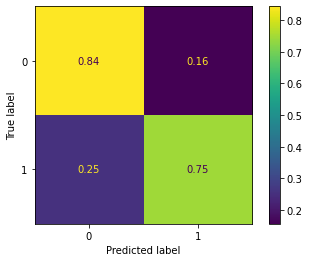

In [ ]:
print(classification_report(val_labels, val_pred))
cm = confusion_matrix(val_labels , val_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       256
           1       0.82      0.75      0.78       244

    accuracy                           0.80       500
   macro avg       0.80      0.79      0.80       500
weighted avg       0.80      0.80      0.80       500



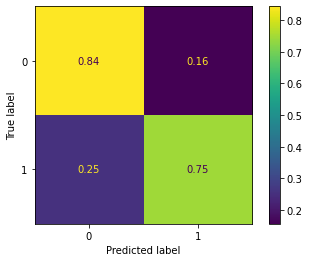

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB()
clf_nb.fit(train_bow, train_labels_splt)
val_pred = clf_nb.predict(val_bow)
print(classification_report(val_labels, val_pred))
cm = confusion_matrix(val_labels , val_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()